In [5]:
!pip install requests rembg pillow ipywidgets onnxruntime -q

print("✅ All libraries installed successfully!")

✅ All libraries installed successfully!


In [6]:
import os
import getpass
HF_API_TOKEN = getpass.getpass('Enter your Hugging Face API Key: ')
SCENE_GENERATION_API_URL = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"
headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}

print("✅ API Key configured.")

Enter your Hugging Face API Key: ··········
✅ API Key configured.


In [7]:
import ipywidgets as widgets
from IPython.display import display
import io
from PIL import Image
uploader = widgets.FileUpload(
    accept='image/*',  # Allow any image type
    multiple=False    # We only want one file
)
prompt_text = widgets.Text(
    value='A product on a marble kitchen counter, professional studio lighting',
    placeholder='Type your scene description...',
    description='Prompt:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

print("Please upload your product image and write a prompt for the background scene.")
display(uploader, prompt_text)

Please upload your product image and write a prompt for the background scene.


FileUpload(value={}, accept='image/*', description='Upload')

Text(value='A product on a marble kitchen counter, professional studio lighting', description='Prompt:', layou…

G.R.A.I.L : (1/3) Removing background from product...
G.R.A.I.L : (2/3) Generating background scene... (This may take up to a minute)
G.R.A.I.L : (3/3) Compositing images and adding shadow...

[SUCCESS] ---- Process Complete! ---- [SUCCESS]


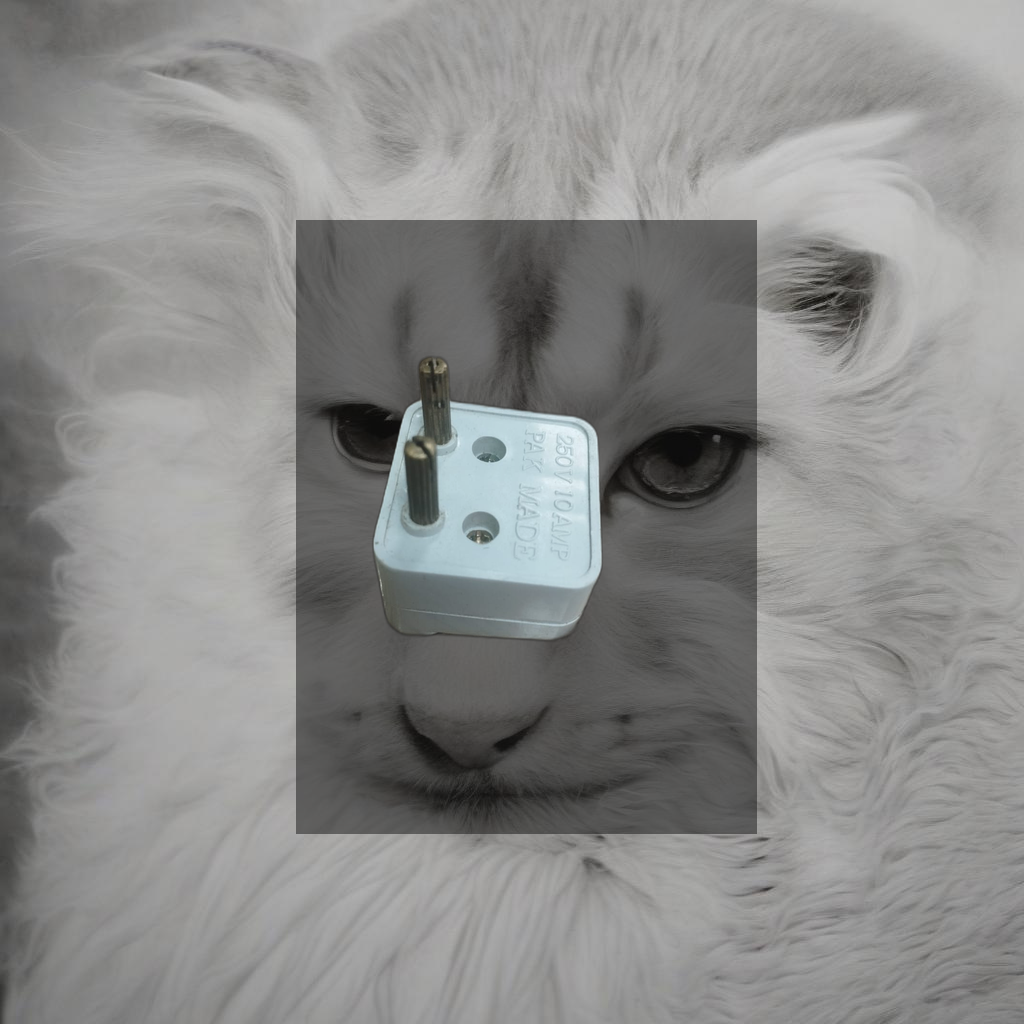

In [9]:
# @title ← Run this cell to generate the final image! (Version with Encoding Fix)

from rembg import remove
import requests
from PIL import Image, ImageFilter
import io

# --- Step 1: Background Removal ---
def remove_background(image_data):
    print("G.R.A.I.L : (1/3) Removing background from product...")
    output_bytes = remove(image_data)
    return Image.open(io.BytesIO(output_bytes))

# --- Step 2: Scene Generation ---
def generate_scene(prompt):
    print("G.R.A.I.L : (2/3) Generating background scene... (This may take up to a minute)")
    response = requests.post(SCENE_GENERATION_API_URL, headers=headers, json={"inputs": prompt})

    # --- THIS IS THE TARGETED FIX ---
    # We explicitly tell the requests library to decode the response using UTF-8.
    # This prevents it from falling back to a problematic default like 'latin-1'.
    response.encoding = 'utf-8'

    if response.status_code != 200:
        # Now that the encoding is fixed, response.text should be safe.
        error_message = f"Error from API: {response.text}"
        print(f"Hugging Face API Error! Status Code: {response.status_code}")
        print(f"Response Body: {error_message}")
        raise Exception(error_message)

    return Image.open(io.BytesIO(response.content))

# --- Step 3: Composition and Shadow ---
def compose_images(product_cutout, background_scene):
    print("G.R.A.I.L : (3/3) Compositing images and adding shadow...")
    bg_w, bg_h = background_scene.size
    if product_cutout.width == 0 or product_cutout.height == 0:
        raise ValueError("Background removal resulted in an empty image.")
    product_ratio = product_cutout.width / product_cutout.height
    new_h = int(bg_h * 0.6)
    new_w = int(new_h * product_ratio)
    product_resized = product_cutout.resize((new_w, new_h), Image.LANCZOS)
    shadow_silhouette = Image.new('RGBA', product_resized.size, (20, 20, 20, 128))
    shadow_blurred = shadow_silhouette.filter(ImageFilter.GaussianBlur(radius=int(new_h * 0.05)))
    final_image = background_scene.copy().convert("RGBA")
    shadow_pos = ((bg_w - new_w) // 2 + 15, (bg_h - new_h) // 2 + 15)
    final_image.paste(shadow_blurred, shadow_pos, shadow_blurred)
    product_pos = ((bg_w - new_w) // 2, (bg_h - new_h) // 2)
    final_image.paste(product_resized, product_pos, product_resized)
    return final_image.convert("RGB")

# --- Main Execution Block ---
try:
    uploaded_file = uploader.value
    if not uploaded_file:
      print("[ERROR] Please upload an image in Cell 3 first!")
    else:
      input_image_data = list(uploaded_file.values())[0]['content']
      user_prompt = prompt_text.value
      product_cutout = remove_background(input_image_data)
      background_scene = generate_scene(user_prompt)
      final_image = compose_images(product_cutout, background_scene)
      print("\n[SUCCESS] ---- Process Complete! ---- [SUCCESS]")
      display(final_image)

except Exception as e:
    # We still keep the sanitization here as a final safety net.
    sanitized_error = str(e).encode('utf-8', 'replace').decode('utf-8')
    print(f"[ERROR] An error occurred during the process: {sanitized_error}")